In [1]:
import pandas as pd
import math
import numpy as np
from datetime import datetime,date
import pytz
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler  
from IPython.core.ultratb import VerboseTB
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
VerboseTB._tb_highlight = "bg:#039dfc"
import scipy.optimize as spo

In [2]:
class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df[column].iloc[offset:]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum
            
        return self.df[f'{column}_momentum_{n}']

    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df[column].iloc[offset:].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']

    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band

    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df[column].iloc[offset:].rolling(window_size).mean()
            self.df[f'{column}_mm20'].iloc[0:window_size] =  self.df[f'{column}_mm20'].iloc[window_size]
            rstd = self.df[column].iloc[offset:].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]

    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df[f'{column}_daily_return'].iloc[0] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df[f'{column}_cumulative_return'].iloc[0] = 0

    def returns(self,column,n):
        self.df[f'{column}_return_{n}'] = (self.df[column] / self.df[column].shift(n)) - 1
        

In [3]:
class portfolio_optimization():
    def __init__(self, data_frame,options):
        self.df = data_frame.copy()
        self.options = options.copy()

    def init_weights(self):
        for stock in self.options:
            if f'{stock}_weight*' not in self.df.columns:
                self.df[f"{stock}_weight"] = 1/len(self.options)
        return self.df[f"{stock}_weight"]

    def _constraints(self, arr):
        return sum(arr) - 1

    def sharpe_ratio(weights, returns, stddev, rfree):
        Total = sum(weights[i]*returns[i] for i in range(0,len(weights)))
        stddev = math.sqrt(sum(weights*returns*std for i in range(0,len(weights))))
        return (Total-rfree)/stddev

    def get_sharpe_ratio(self, rfree):
        self.df["Sharpe_Ratio"] = df.apply(lambda row:sharpe_ratio(row["*_weight"],row["*_return"],row["*_stddev"],rfree))
        return self.df["Sharpe_Ratio"]

    def target_function(weights, returns,stddev,rfree):
        return -sharpe_ratio(weights,returns, stddev, rfree)
        
    
    def optmize_weights(weights, returns, stddev, rfree):
        initial_weights = weights
        result = spo.minimize(target_function, 
                              initial_weights, 
                              args=(returns, stddev, rfree),
                              constraints=_constraints, 
                              bounds=[(0,1) for x in range(len(weights))]
                              )
        optimal_weights = result.x
        return optimal_weights

    def get_optimal_weights(self,rfree):                              
        self.df["*_weight"] = df.apply(lambda row:(row["*_weight"],row["*_return"],row["*_stddev"],rfree))
        return self.df["Sharpe_Ratio"]
    

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X, y = make_regression(n_samples=200, random_state=1)
print("X equals")
print(X)
print(len(X[0]))
print("y equals")
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
print(X_train,y_train)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
regr.predict(X_test[:2])
regr.score(X_test, y_test)

X equals
[[ 4.35964951e-01  6.56278975e-01  4.80179809e-04 ... -2.17373330e+00
  -4.53751512e-01 -1.53885818e-01]
 [-1.04054030e+00 -2.19631333e-03  1.41229617e+00 ... -1.24838837e+00
   3.09657106e-01  7.13107100e-01]
 [-6.28817482e-01 -4.36684080e-01  1.49088673e-01 ...  1.16895233e+00
  -9.38234025e-03 -1.40959504e+00]
 ...
 [ 1.58814951e+00  6.05600808e-01 -1.65709505e+00 ...  6.75282576e-01
  -8.59941103e-01  1.03056340e+00]
 [-8.57014517e-01  1.21629894e+00  9.70696111e-01 ...  1.47511687e+00
   1.21356892e+00 -9.84514530e-01]
 [-2.45389193e+00 -1.43403073e+00  5.40533161e-01 ...  9.52547818e-01
   5.49421827e-01  2.07229946e-01]]
100
y equals
[-3.85217603e+01  1.12467601e+02 -3.44345090e+02  1.82630283e+02
  2.39473441e+02 -5.29145377e+01 -1.90797752e+01  1.48663488e+02
  9.59532286e+01 -2.08045947e+01 -4.99385124e+01  9.97128986e+01
 -1.04668089e+02  1.89481810e+02 -2.16615457e+02 -2.17710850e+02
 -1.63052960e+02  1.71269972e+02  1.98236402e+02 -1.33636109e+02
  1.03148910e+02 

/opt/miniconda3/envs/trading/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.4162338898076595

In [5]:
def get_stock_data(ticker,start,end):
    start_date = date.fromisoformat(start)
    end_date = date.fromisoformat(end)
    start_stamp = int(datetime(start_date.year, start_date.month, start_date.day, tzinfo=pytz.UTC).timestamp())
    end_stamp = int(datetime(end_date.year, end_date.month, end_date.day, tzinfo=pytz.UTC).timestamp())
    print(start_date, end_date)
    #start_stamp = datetime.timestamp(start_date)
    #end_stamp = datetime.timestamp(end_date)
    print(start_stamp,end_stamp)
    url = "https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%i&period2=%i&interval=1d&events=history&includeAdjustedClose=true" % (ticker,start_stamp, end_stamp)
    print(url)
    stock = pd.read_csv(url)
    print(stock)
    # Create a MinMaxScaler object

    scaler = StandardScaler()  
    # Define the column to leave unchanged
    unchanged_column = 'Date'
    
    stock['Date'] = pd.to_datetime(stock['Date'])
    stock['Year'] = stock['Date'].dt.year
    stock['Month'] = stock['Date'].dt.month
    stock['Day'] = stock['Date'].dt.day
    
    # Create a subset of columns excluding the unchanged column
    columns_to_scale = [col for col in stock.columns if col != unchanged_column]

    # Copy the DataFrame
    stock_normalized = stock.copy()

    # Apply MinMaxScaler to the subset of columns
    stock_normalized[columns_to_scale] = scaler.fit_transform(stock[columns_to_scale])

    print(stock_normalized)
    
    # Concatenate the normalized subset with the unchanged column
    stock_normalized = pd.concat([stock_normalized[unchanged_column], stock_normalized[columns_to_scale]], axis=1)

    stock_normalized.rename(columns={"Adj Close":"AC"}, inplace=True)
    
    return stock_normalized



In [6]:
   options = ["ITUB4.SA",
              "VALE3.SA"
             ] 

In [7]:
def merge_stocks(options):
    df = pd.DataFrame()
    for stock in options:
        print("stock =",stock)
        df_stock=get_stock_data(stock,"2010-01-01","2021-12-31")
        date_columns = ["Date","Year","Month","Day"]
        # Identify columns with identical values across all DataFrames
        identical_columns = []
        distinct_columns = []

        for col in df_stock.columns:
            if (col in df and col in df_stock):
                if df[col].equals(df_stock[col]): identical_columns.append(col)
            else: 
                if col not in date_columns: df_stock.rename(columns={col: stock + '_' + col}, inplace=True)
        # Identify columns with distinct values across the DataFrames
        distinct_columns = [col for col in df_stock.columns if col not in identical_columns]

        df = pd.concat([df,df_stock[distinct_columns]],axis=1)
    print(df)
    return df

In [8]:
df = merge_stocks(options)
#Itau = get_stock_data("ITUB4.SA","2010-01-01","2021-12-31")
#Vale = get_stock_data("VALE3.SA","2010-01-01","2021-12-31")
#Itau.merge(Vale)
#print(Itau)
#print(type(Itau)) 
#df = result = pd.concat([Vale, Itau], axis=1, keys=['Vale', 'Itau'])
#print("is there a null?",df.isnull().values.any())
#print(df)
#df_reshaped = df.stack().unstack(level=[1]).reset_index(drop=True)
#print(df_reshaped)
#print(df_reshaped.iloc[:, :-1].values)

stock = ITUB4.SA
2010-01-01 2021-12-31
1262304000 1640908800
https://query1.finance.yahoo.com/v7/finance/download/ITUB4.SA?period1=1262304000&period2=1640908800&interval=1d&events=history&includeAdjustedClose=true
            Date       Open       High        Low      Close  Adj Close  \
0     2010-01-04  17.708261  18.436810  17.708261  18.268333  10.141706   
1     2010-01-05  18.313868  18.386723  18.168158  18.386723  10.207432   
2     2010-01-06  18.327526  18.436810  18.077089  18.227352  10.118953   
3     2010-01-07  18.099855  18.236460  18.008787  18.040663  10.015312   
4     2010-01-08  18.113516  18.113516  17.721922  17.767456   9.863636   
...          ...        ...        ...        ...        ...        ...   
2970  2021-12-23  21.330000  21.570000  21.170000  21.340000  18.776709   
2971  2021-12-27  21.480000  21.700001  21.309999  21.559999  18.970284   
2972  2021-12-28  21.629999  21.700001  21.400000  21.480000  18.899893   
2973  2021-12-29  21.530001  21.5800

In [9]:
#print(df.xs("Adj Close",axis=1,level=1))
#xsdf = df.xs("Adj Close",axis=1,level=1)
#print(len(xsdf))
Train_Data = df[:round(len(df)/2)]
print(Train_Data)
Test_Data = df[round(len(df)/2):]
print(Test_Data)

           Date  ITUB4.SA_Open  ITUB4.SA_High  ITUB4.SA_Low  ITUB4.SA_Close  \
0    2010-01-04      -0.649247      -0.579852     -0.614727       -0.569811   
1    2010-01-05      -0.563651      -0.586855     -0.548941       -0.553056   
2    2010-01-06      -0.561721      -0.579852     -0.561968       -0.575610   
3    2010-01-07      -0.593899      -0.607864     -0.571738       -0.602031   
4    2010-01-08      -0.591969      -0.625053     -0.612772       -0.640695   
...         ...            ...            ...           ...             ...   
1483 2016-01-04      -0.931808      -0.946820     -0.969184       -0.999754   
1484 2016-01-05      -0.976352      -0.973088     -0.973519       -0.981743   
1485 2016-01-06      -1.010616      -0.968851     -0.997793       -0.990320   
1486 2016-01-07      -1.019182      -1.014608     -1.001261       -1.031489   
1487 2016-01-08      -1.014899      -1.017998     -1.000394       -1.030631   

      ITUB4.SA_AC  ITUB4.SA_Volume      Year     Mo

In [17]:
rwin = 90
offset = 1
Train_Sample_Array = []
Train_Result_Array = []
#scaler = MinMaxScaler()
Test_Sample_Array = []
Test_Result_Array = []

features = ["VALE3.SA_AC","ITUB4.SA_AC"]
targets = ["VALE3.SA_AC","ITUB4.SA_AC"]
#Normalized_Train_Data = Train_Data.copy() 
#Normalized_Test_Data = Test_Data.copy()
# Create a subset of columns excluding the unchanged column
#columns_to_scale = [col for col in Train_Data.columns]


#Normalized_Train_Data[columns_to_scale] = scaler.fit_transform(Train_Data[columns_to_scale])
#Normalized_Test_Data[columns_to_scale] = scaler.fit_transform(Test_Data[columns_to_scale])
#print(Normalized_Train_Data)
#print(Normalized_Test_Data)

In [18]:
for i in range(0,len(Train_Data)-rwin - offset):
    Train_Sample = Train_Data[features].iloc[i:i+rwin]
    Train_Sample_row = Train_Sample.values.flatten()
    Train_Sample_Array.append(Train_Sample_row)
    Train_Result = Train_Data[targets].iloc[i+rwin]
    Train_Result_Array.append(Train_Result.values)
for i in range(0,len(Test_Data)-rwin - offset):
    Test_Sample = Test_Data[features].iloc[i:i+rwin]
    Test_Sample_row = Test_Sample.values.flatten()
    Test_Sample_Array.append(Test_Sample_row)
    Test_Result = Test_Data[targets].iloc[i+rwin + offset]
    Test_Result_Array.append(Test_Result.values)
print("Train_Sample_Array:",Train_Sample_Array)
#print(Result_Array)
print("Test_Sample_Array:",Test_Sample_Array)
#print("Test_Result_Array:",Test_Result_Array)

Train_Sample_Array: [array([-0.17463534, -0.83440445, -0.16134105, -0.82522885, -0.13087513,
       -0.83758086, -0.12478183, -0.85204956, -0.11037948, -0.87322412,
       -0.11481118, -0.88522085, -0.1189657 , -0.89792662, -0.10068618,
       -0.89369132, -0.10096335, -0.91239476, -0.1203505 , -0.9349803 ,
       -0.09957849, -0.92333412, -0.07880574, -0.92686415, -0.1203505 ,
       -0.96180045, -0.17158887, -0.98544433, -0.20177757, -0.97097522,
       -0.23002793, -0.96779979, -0.24886142, -0.98615017, -0.24969201,
       -0.94839135, -0.24609163, -0.97521039, -0.20510133, -0.95121317,
       -0.20510133, -0.93392238, -0.20814761, -0.93956797, -0.28348126,
       -0.99003242, -0.29456004, -1.02214607, -0.28514366, -1.02567428,
       -0.25744684, -0.97097522, -0.25606259, -0.9639181 , -0.22448848,
       -0.94133298, -0.23390504, -0.94168562, -0.1798975 , -0.91345449,
       -0.15580173, -0.90921974, -0.1605101 , -0.93039208, -0.18820661,
       -0.95791848, -0.2098094 , -0.9794454

Test_Sample_Array: [array([-1.22820457, -0.8531273 , -1.25839839, -0.84684861, -1.27331341,
       -0.86853552, -1.24966765, -0.84856099, -1.25985353, -0.88508669,
       -1.27731501, -0.90106618, -1.2667653 , -0.91476328, -1.26567399,
       -0.93359752, -1.26822044, -0.93074332, -1.2722221 , -0.91818734,
       -1.27513239, -0.90391968, -1.25839839, -0.89878323, -1.26130862,
       -0.88965272, -1.2471212 , -0.82630268, -1.25512439, -0.79575091,
       -1.28786466, -0.90025452, -1.27294964, -0.86770418, -1.22456681,
       -0.84771806, -1.22856841, -0.83401189, -1.22965972, -0.82715999,
       -1.24166445, -0.86941824, -1.22784074, -0.85856697, -1.21838252,
       -0.86313578, -1.19000756, -0.82944488, -1.16745311, -0.81402605,
       -1.1820043 , -0.84314813, -1.1703634 , -0.82646588, -1.12270804,
       -0.76897516, -1.15035547, -0.79009374, -1.17472877, -0.80241379,
       -1.19982961, -0.80123944, -1.20055721, -0.80123944, -1.17109082,
       -0.76017592, -1.13471284, -0.69003178

In [ ]:

print(len(Sample_Array))
for row in Sample_Array:
    print(len(row), row.ndim)
print(len(Test_Sample_Array))
for row in Test_Sample_Array:
    print(len(row), row.ndim)

In [19]:
regr = MLPRegressor(random_state=1, max_iter=1000, hidden_layer_sizes=(50,50,50,50,50),learning_rate_init = 0.000001, tol = 0.000001).fit(Train_Sample_Array, Train_Result_Array)
#print(regr)
Res = pd.DataFrame(regr.predict(Test_Sample_Array[:]),columns=[targets])
#Res = regr.predict(Test_Sample_Array[:])
print(Res)
#print(len(Sample_Array) + rwin,len(Sample_Array) + len(Test_Sample_Array))
#print(len(Train_Data) + rwin + offset,len(Train_Data) + len(Test_Data)+ rwin+offset)
#print(len(Res))
New_index_values = range(len(Train_Data) + rwin + offset,len(Train_Data) + len(Test_Data))
Res.index = New_index_values
print(Res)

     VALE3.SA_AC ITUB4.SA_AC
0      -0.301178   -0.062272
1      -0.299891   -0.053255
2      -0.321677   -0.063824
3      -0.324641   -0.077009
4      -0.308832   -0.072533
...          ...         ...
1391    0.601408    1.088777
1392    0.627540    1.134344
1393    0.621974    1.093904
1394    0.632181    1.105272
1395    0.642602    1.063913

[1396 rows x 2 columns]
     VALE3.SA_AC ITUB4.SA_AC
1579   -0.301178   -0.062272
1580   -0.299891   -0.053255
1581   -0.321677   -0.063824
1582   -0.324641   -0.077009
1583   -0.308832   -0.072533
...          ...         ...
2970    0.601408    1.088777
2971    0.627540    1.134344
2972    0.621974    1.093904
2973    0.632181    1.105272
2974    0.642602    1.063913

[1396 rows x 2 columns]


/opt/miniconda3/envs/trading/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
Train_Res = pd.DataFrame(regr.predict(Train_Sample_Array[:]),columns=[targets])
#Train_Res = regr.predict(Sample_Array[:])
#print(len(Sample_Array) + rwin,len(Sample_Array) + len(Test_Sample_Array))
New_index_values = range(rwin + offset,len(Train_Data))
Train_Res.index = New_index_values
print(Train_Res)

     VALE3.SA_AC ITUB4.SA_AC
91      0.048306    0.015410
92      0.033480    0.005392
93      0.038723    0.005281
94      0.037650    0.004749
95      0.030153   -0.001420
...          ...         ...
1483   -0.391566   -0.102021
1484   -0.383598   -0.102607
1485   -0.398162   -0.101802
1486   -0.390133   -0.105271
1487   -0.380601   -0.112548

[1397 rows x 2 columns]


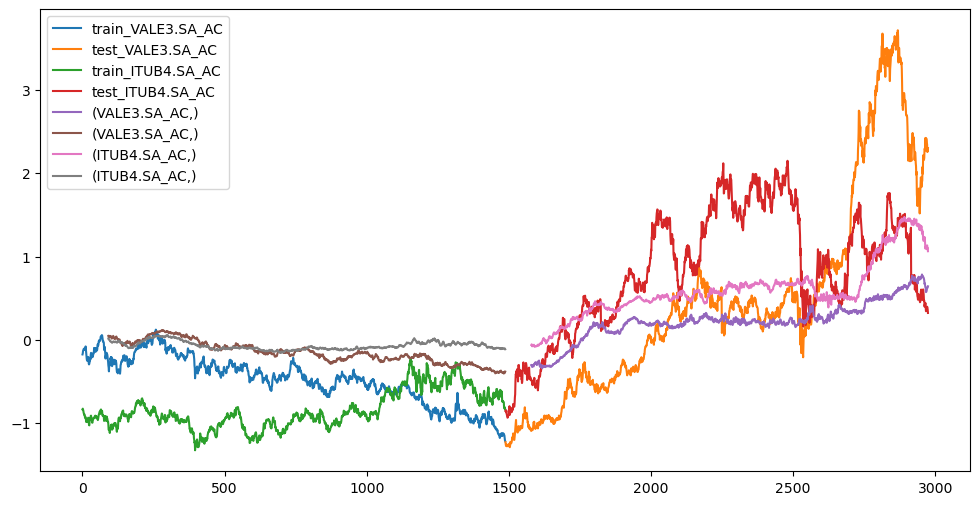

In [23]:

fig, ax = plt.subplots(figsize=(12, 6))
for feature in features:
    Train_Data[feature].plot(ax=ax, label='train_' + feature)
    Test_Data[feature].plot(ax=ax, label='test_' + feature)
for target in targets:    
    Res[target].plot(ax=ax,label="Prediction_" + target)
    Train_Res[target].plot(ax=ax,label="Train_Prediction_" + target)
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
common_indices = Normalized_Train_Data['Vale'].index.intersection(Train_Res['Vale'].index)
common_indices = common_indices[:-1]
Train_Diff = Normalized_Train_Data['Vale'].loc[common_indices] - Train_Res['Vale'].loc[common_indices] 
common_indices = Normalized_Test_Data['Vale'].index.intersection(Res['Vale'].index)
common_indices = common_indices[:-1]
Test_Diff = Normalized_Test_Data['Vale'].loc[common_indices] - Res["Vale"].loc[common_indices]
Train_Diff.plot(ax=ax, label='train')
Test_Diff.plot(ax=ax, label='test')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
common_indices = Normalized_Train_Data['Vale'].index.intersection(Train_Res['Vale'].index)
common_indices = common_indices[:-1]
Train_data_stddev = Normalized_Train_Data['Vale'].loc[common_indices].std()
Train_pred_stddev = Train_Res['Vale'].loc[common_indices].std()
print(Train_data_stddev)
Train_Pull = Train_Diff/math.sqrt(pow(Train_data_stddev,2) + pow(Train_pred_stddev,2))
Train_Pull.plot(ax=ax, label='train')

common_indices = Normalized_Test_Data['Vale'].index.intersection(Res['Vale'].index)
common_indices = common_indices[:-1]
Test_data_stddev = Normalized_Test_Data['Vale'].loc[common_indices].std()
Test_pred_stddev = Res['Vale'].loc[common_indices].std()
print(Test_data_stddev)
Test_Pull = Test_Diff/math.sqrt(pow(Test_data_stddev,2) + pow(Test_pred_stddev,2))
Test_Pull.plot(ax=ax, label='train')

In [ ]:
class Metrics():
    def __init__(self, in_df, pred_df):
        common_indices = in_df.index.intersection(pred_df.index)
        common_indices = common_indices[:-1]
        self.in_df = in_df.loc[common_indices].copy()
        self.pred_df = pred_df.loc[common_indices].copy()
        self.out = pd.DataFrame()
        self.mse = {}

    def pull(self):
        for column in self.pred_df.columns:
            diff = self.pred_df[column] - self.in_df[column] 
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            pull = diff/math.sqrt(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_Pull'] = pull

    def chisq(self):
        for column in self.pred_df.columns:
            diff = self.pred_df[column] - self.in_df[column] 
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            chisq = diff*diff/(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_ChiSq'] = chisq
    
    def get_mse(self):
        for column in self.pred_df.columns:
            if f'{column}_ChiSq' not in self.out.columns:
                self.chisq()
            self.mse[column] = self.out[f'{column}_ChiSq'].sum()/len(self.out[f'{column}_ChiSq'])

In [ ]:
M_Train = Metrics(Normalized_Train_Data,Train_Res)
print(M_Train.pull())
print(M_Train.chisq())

print(M_Train.get_mse())
print(M_Train.out)
print(M_Train.mse)
M_Test = Metrics(Normalized_Test_Data,Res)
print(M_Test.pull())
print(M_Test.chisq())

print(M_Test.get_mse())
print(M_Test.out)
print(M_Test.mse)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
Normalized_Train_Data['Itau'].plot(ax=ax, label='train')
Normalized_Test_Data['Itau'].plot(ax=ax, label='test')
Res['Itau'].plot(ax=ax,label="Prediction")
Train_Res['Itau'].plot(ax=ax,label="Train_Prediction")
ax.legend();

In [ ]:
Normalized_Train_Data.columns[0]


In [ ]:
class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df[column].iloc[offset:]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum
            
        return self.df[f'{column}_momentum_{n}']

    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df[column].iloc[offset:].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']

    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band

    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df[column].iloc[offset:].rolling(window_size).mean()
            self.df[f'{column}_mm20'].iloc[0:window_size] =  self.df[f'{column}_mm20'].iloc[window_size]
            rstd = self.df[column].iloc[offset:].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]

    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df[f'{column}_daily_return'].iloc[0] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df[f'{column}_cumulative_return'].iloc[0] = 0

In [ ]:
TF = TechnicalIndicators(Normalized_Train_Data)
print(TF.df)
print(type(TF.df))
for column in Normalized_Train_Data:
    print(TF.momentum(column,15))
    print(TF.simple_movement_average(column,15))
    print(TF.bollinger_bands(column,15))
    print(TF.add_daily_return(column))
print(TF.df)

In [ ]:
import torch
from torch import nn
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
print(h0,c0,hn,cn,output)

In [ ]:
df = pd.DataFrame(np.random.rand(5, 3), columns=list('abc'))
print(df)
print(df.index)
df = df[1:5]
print(df)
print(df.iloc[1])


In [ ]:
df1 = pd.DataFrame(np.random.rand(5, 3), columns=list('abc'))

# Create the second DataFrame with shifted indices
df2 = pd.DataFrame(np.random.rand(5, 3), columns=list('def'), index=range(1, 6))

# Find the common indices between df1 and df2
common_indices = df1.index.intersection(df2.index)

# Use loc[] to select only the rows with common indices from each DataFrame
df1_common = df1.loc[common_indices]
df2_common = df2.loc[common_indices]

# Now you can perform operations between df1_common and df2_common without getting NaN values
result = df1_common + df2_common
print(result)

In [ ]:
coefs = regr.coefs_
# Iterate through the weights of each layer
for i, coef in enumerate(coefs):
    print(f"Layer {i}:")
    for j, weights in enumerate(columns):
        for k, weight in enumerate(weights):
            for l, element in enumerate(weight):
                print(f"    Weight from input feature {k} to neuron {j} of prediction of {l} in layer {i}: {element}")
layer_1_coefficients = coefs[0]
print(layer_1_coefficients[:,0])

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
plt.plot(layer_1_coefficients[:,0])